In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import os
import argparse
from pathlib import Path
import re
import random
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Keras

In [11]:
# -*- coding: utf-8 -*-
# CSV → 2D "image" classifier in Keras.
# Split = 80% train / 10% val / 10% test (stratified).
# Save the model with BEST **validation accuracy**, then LOAD it and evaluate on the TEST set.

from pathlib import Path
import re, random, math, os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# Config
# =========================
SPLIT_DIR = r"/content/drive/MyDrive/CD/patient_data_clean_600s"
POS_PATIENTS = {1, 2, 4, 11, 16, 19, 20, 21, 22, 25, 28, 32, 37, 38, 39, 42, 43, 44, 46, 49, 50, 51, 55, 56, 58, 59, 61, 62, 64, 65, 66, 67, 69, 73, 78}

STANDARDIZE = "zscore"              # "zscore", "minmax", or None
BATCH_SIZE  = 32
EPOCHS      = 100
LR          = 1e-4
SEED        = 1337
BEST_MODEL_PATH = "best_keras_img_by_val_acc.h5"

# Target image height (rows). Width will be inferred from the first TRAIN CSV (after dropping cols).
TARGET_H = 3600

# =========================
# Repro
# =========================
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

for g in tf.config.list_physical_devices('GPU'):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# =========================
# Helpers for ID/labels
# =========================
PATIENT_NUM_RX = re.compile(r'^ID(\d+)')
BASE_ID_RX     = re.compile(r'^(ID\d+(?:-\d+)?)')

def patient_num_from_path(pathlike):
    stem = Path(pathlike).stem
    m = PATIENT_NUM_RX.match(stem)
    return int(m.group(1)) if m else None

def base_id_from_path(pathlike):
    stem = Path(pathlike).stem
    m = BASE_ID_RX.match(stem)
    return m.group(1) if m else stem

def label_for_file(p: Path):
    pnum = patient_num_from_path(p)
    return 1 if (pnum is not None and pnum in POS_PATIENTS) else 0

# =========================
# List files & make 80/10/10 stratified splits
# =========================
split_dir = Path(SPLIT_DIR)
all_csvs = sorted(split_dir.glob("*.csv"))
if not all_csvs:
    raise FileNotFoundError(f"No CSV found in {SPLIT_DIR}")

y_all = np.array([label_for_file(p) for p in all_csvs], dtype=int)

# First: hold out 10% for TEST
trainval_files, test_files = train_test_split(
    all_csvs, test_size=0.10, random_state=SEED, stratify=y_all
)
y_trainval = np.array([label_for_file(p) for p in trainval_files], dtype=int)

# Second: from remaining 90%, carve out 10% of original for VAL = 1/9 ≈ 0.111...
train_files, val_files = train_test_split(
    trainval_files, test_size=0.1111111, random_state=SEED, stratify=y_trainval
)

# =========================
# Image loader utilities
# =========================
def _to_numeric_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(pd.to_numeric, errors="coerce").fillna(0.0)

def _standardize_img(img: np.ndarray, mode=STANDARDIZE) -> np.ndarray:
    if mode is None:
        return img
    if mode == "zscore":
        m = np.mean(img, keepdims=True)
        s = np.std(img, keepdims=True) + 1e-8
        return (img - m) / s
    if mode == "minmax":
        mn = np.min(img, keepdims=True)
        mx = np.max(img, keepdims=True)
        return (img - mn) / (mx - mn + 1e-8)
    return img

def _pad_crop_2d(x: np.ndarray, H: int, W: int) -> np.ndarray:
    h, w = x.shape
    if h < H:
        pad = np.zeros((H, w), dtype=x.dtype); pad[:h, :] = x; x = pad; h = H
    elif h > H:
        x = x[:H, :]; h = H
    if w < W:
        pad = np.zeros((h, W), dtype=x.dtype); pad[:, :w] = x; x = pad
    elif w > W:
        x = x[:, :W]
    return x

def _infer_target_width(example_csv: Path) -> int:
    df = pd.read_csv(example_csv)
    if df.shape[1] <= 8:
        raise ValueError(f"{example_csv} has <= 8 columns; cannot drop first + last 7.")
    df2 = df.iloc[:, 1:-7]
    df2 = _to_numeric_df(df2)
    return df2.shape[1]

# infer width from a TRAIN file
if not len(train_files):
    raise RuntimeError("Empty training split after splitting; check your data.")
TARGET_W = _infer_target_width(train_files[0])

def load_csv_as_image(csv_path: Path) -> np.ndarray:
    df = pd.read_csv(csv_path)
    if df.shape[1] <= 8:
        raise ValueError(f"{csv_path} has <= 8 columns; cannot drop first + last 7.")
    df2 = df.iloc[:, 1:-7]
    df2 = _to_numeric_df(df2)
    mat = df2.to_numpy(dtype=np.float32)
    mat = _pad_crop_2d(mat, TARGET_H, TARGET_W)
    img = mat[:, :, None]
    img = _standardize_img(img, STANDARDIZE).astype(np.float32)
    return img

CACHE = {}
def load_csv_as_image_cached(csv_path: Path) -> np.ndarray:
    key = str(csv_path)
    if key in CACHE:
        return CACHE[key]
    img = load_csv_as_image(csv_path)
    CACHE[key] = img
    return img

# =========================
# Keras Sequence
# =========================
class ImageSequence(keras.utils.Sequence):
    def __init__(self, files, batch_size=BATCH_SIZE, shuffle=True):
        super().__init__()
        self.files = list(files)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.files) / self.batch_size)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, idx):
        idxs = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_files = [self.files[i] for i in idxs]
        X_list, y_list = [], []
        for f in batch_files:
            X_list.append(load_csv_as_image_cached(f))
            y_list.append(label_for_file(f))
        return np.stack(X_list, 0), np.array(y_list, dtype=np.int32)

# =========================
# DenseNet-style 2D CNN (binary head)
# =========================
def build_model(h=TARGET_H, w=TARGET_W, c=1, lr=LR,
                growth_rate=8, block_layers=(4, 6, 6, 6),
                compression=0.5, dropout=0.2):

    inputs = keras.Input(shape=(h, w, c))

    def bn_relu_conv(x, filters, ksize, stride=1):
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, ksize, strides=stride, padding="same", use_bias=False)(x)
        return x

    def dense_layer(x):
        y = bn_relu_conv(x, 4 * growth_rate, 1)
        y = bn_relu_conv(y, growth_rate, 3)
        return layers.Concatenate()([x, y])

    def dense_block(x, L):
        for _ in range(L):
            x = dense_layer(x)
        return x

    def transition_layer(x):
        filters = max(8, int(int(x.shape[-1]) * compression))
        x = bn_relu_conv(x, filters, 1)
        return layers.AveragePooling2D(pool_size=(2, 2), strides=2, padding="same")(x)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    for i, L in enumerate(block_layers):
        x = dense_block(x, L)
        if i != len(block_layers) - 1:
            x = transition_layer(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[keras.metrics.BinaryAccuracy(name="acc"), keras.metrics.AUC(name="auc")],
    )
    return model

# =========================
# Data generators
# =========================
train_gen = ImageSequence(train_files, batch_size=BATCH_SIZE, shuffle=True)
val_gen   = ImageSequence(val_files,   batch_size=BATCH_SIZE, shuffle=False)

# =========================
# Train (save BEST by **validation accuracy**)
# =========================
model = build_model()
ckpt = keras.callbacks.ModelCheckpoint(
    BEST_MODEL_PATH, monitor="val_acc", mode="max", save_best_only=True, verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[ckpt],        # no early stopping
    verbose=1,
    # workers=4, use_multiprocessing=True, max_queue_size=16,  # optional
)

# =========================
# LOAD the BEST model (by val accuracy) and TEST on the 10% test set
# =========================
best_model = keras.models.load_model(BEST_MODEL_PATH)

X_test = np.stack([load_csv_as_image_cached(f) for f in test_files], axis=0)
y_true = np.array([label_for_file(f) for f in test_files], dtype=int)

probs1 = best_model.predict(X_test, verbose=0).ravel().astype(float)
y_pred = (probs1 >= 0.5).astype(int)

try:
    auc = roc_auc_score(y_true, probs1)
except ValueError:
    auc = float('nan')
acc = accuracy_score(y_true, y_pred)

print(f"\nEVALUATED MODEL: {BEST_MODEL_PATH} (selected by best VAL accuracy)")
print(f"Image shape used: H={TARGET_H}, W={TARGET_W}, C=1")
print(f"Test acc {acc:.3f}, AUC {auc:.3f}")
print("\nConfusion matrix (test):\n", confusion_matrix(y_true, y_pred))
print("\nClassification report (test):\n", classification_report(y_true, y_pred, digits=3))


Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - acc: 0.5238 - auc: 0.5307 - loss: 0.6925
Epoch 1: val_acc improved from -inf to 0.53223, saving model to best_keras_img_by_val_acc.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 143s 617ms/step - acc: 0.5239 - auc: 0.5308 - loss: 0.6925 - val_acc: 0.5322 - val_auc: 0.5159 - val_loss: 0.6929
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.5347 - auc: 0.5457 - loss: 0.6881
Epoch 2: val_acc did not improve from 0.53223
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.5347 - auc: 0.5457 - loss: 0.6881 - val_acc: 0.4843 - val_auc: 0.5269 - val_loss: 0.6936
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.5457 - auc: 0.5595 - loss: 0.6847
Epoch 3: val_acc did not improve from 0.53223
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.5457 - auc: 0.5596 - loss: 0.6847 - val_acc: 0.4992 - val_auc: 0.5362 - val_loss: 0.6865
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - acc: 0.5367 - auc: 0.5583 - loss: 0.6833
Epoch 4: val_acc did not improve from 0.53223
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.5367 - auc: 0.5583 - loss: 0.6833 - val_acc: 0.5322 - val_auc: 0.5437 - val_loss: 0.6815

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.7886 - auc: 0.8791 - loss: 0.4407 - val_acc: 0.5983 - val_auc: 0.6700 - val_loss: 0.8651
Epoch 10/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.8253 - auc: 0.9050 - loss: 0.3905
Epoch 10: val_acc did not improve from 0.59835
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.8253 - auc: 0.9050 - loss: 0.3905 - val_acc: 0.5455 - val_auc: 0.8135 - val_loss: 1.1163
Epoch 11/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.8473 - auc: 0.9286 - loss: 0.3423
Epoch 11: val_acc improved from 0.59835 to 0.72231, saving model to best_keras_img_by_val_acc.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - acc: 0.8473 - auc: 0.9286 - loss: 0.3423 - val_acc: 0.7223 - val_auc: 0.8433 - val_loss: 0.5998
Epoch 12/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.8638 - auc: 0.9420 - loss: 0.3098
Epoch 12: val_acc improved from 0.72231 to 0.83967, saving model to best_keras_img_by_val_acc.h5


151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.8639 - auc: 0.9421 - loss: 0.3098 - val_acc: 0.8397 - val_auc: 0.9259 - val_loss: 0.3539
Epoch 13/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.8762 - auc: 0.9489 - loss: 0.2932
Epoch 13: val_acc did not improve from 0.83967
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.8762 - auc: 0.9489 - loss: 0.2931 - val_acc: 0.7719 - val_auc: 0.8427 - val_loss: 0.5778
Epoch 14/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.8865 - auc: 0.9604 - loss: 0.2570
Epoch 14: val_acc did not improve from 0.83967
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.8866 - auc: 0.9604 - loss: 0.2569 - val_acc: 0.6050 - val_auc: 0.8414 - val_loss: 1.4080
Epoch 15/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9109 - auc: 0.9719 - loss: 0.2161
Epoch 15: val_acc did not improve from 0.83967
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - acc: 0.9109 - auc: 0.9719 - loss: 0.2162 - val_acc: 0.6562 - val_auc: 0.8880 - val_loss: 1

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.9572 - auc: 0.9927 - loss: 0.1076 - val_acc: 0.9455 - val_auc: 0.9941 - val_loss: 0.1256
Epoch 25/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9623 - auc: 0.9945 - loss: 0.0950
Epoch 25: val_acc did not improve from 0.94545
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9623 - auc: 0.9945 - loss: 0.0950 - val_acc: 0.9256 - val_auc: 0.9839 - val_loss: 0.2012
Epoch 26/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9625 - auc: 0.9946 - loss: 0.0904
Epoch 26: val_acc did not improve from 0.94545
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9625 - auc: 0.9946 - loss: 0.0905 - val_acc: 0.9041 - val_auc: 0.9839 - val_loss: 0.2350
Epoch 27/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - acc: 0.9629 - auc: 0.9933 - loss: 0.1000
Epoch 27: val_acc did not improve from 0.94545
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9629 - auc: 0.9933 - loss: 0.1000 - val_acc: 0.8975 - val_auc: 0.9701 - val_loss: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.9735 - auc: 0.9964 - loss: 0.0719 - val_acc: 0.9752 - val_auc: 0.9978 - val_loss: 0.0692
Epoch 33/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9666 - auc: 0.9963 - loss: 0.0759
Epoch 33: val_acc did not improve from 0.97521
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9666 - auc: 0.9963 - loss: 0.0759 - val_acc: 0.6628 - val_auc: 0.7300 - val_loss: 0.6909
Epoch 34/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9683 - auc: 0.9952 - loss: 0.0842
Epoch 34: val_acc did not improve from 0.97521
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9684 - auc: 0.9952 - loss: 0.0841 - val_acc: 0.8893 - val_auc: 0.9807 - val_loss: 0.2642
Epoch 35/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9711 - auc: 0.9963 - loss: 0.0747
Epoch 35: val_acc did not improve from 0.97521
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9711 - auc: 0.9963 - loss: 0.0746 - val_acc: 0.8793 - val_auc: 0.9961 - val_loss: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 243ms/step - acc: 0.9839 - auc: 0.9989 - loss: 0.0422 - val_acc: 0.9901 - val_auc: 0.9996 - val_loss: 0.0253
Epoch 51/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9772 - auc: 0.9983 - loss: 0.0521
Epoch 51: val_acc did not improve from 0.99008
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9772 - auc: 0.9983 - loss: 0.0520 - val_acc: 0.8744 - val_auc: 0.9621 - val_loss: 0.2565
Epoch 52/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9826 - auc: 0.9991 - loss: 0.0401
Epoch 52: val_acc did not improve from 0.99008
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9826 - auc: 0.9991 - loss: 0.0400 - val_acc: 0.9488 - val_auc: 0.9825 - val_loss: 0.1808
Epoch 53/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9797 - auc: 0.9983 - loss: 0.0550
Epoch 53: val_acc did not improve from 0.99008
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9797 - auc: 0.9983 - loss: 0.0549 - val_acc: 0.9388 - val_auc: 0.9773 - val_loss: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.9869 - auc: 0.9987 - loss: 0.0349 - val_acc: 0.9917 - val_auc: 0.9996 - val_loss: 0.0268
Epoch 80/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9897 - auc: 0.9993 - loss: 0.0255
Epoch 80: val_acc did not improve from 0.99174
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9897 - auc: 0.9993 - loss: 0.0255 - val_acc: 0.9521 - val_auc: 0.9933 - val_loss: 0.1360
Epoch 81/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9902 - auc: 0.9997 - loss: 0.0220
Epoch 81: val_acc did not improve from 0.99174
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9901 - auc: 0.9997 - loss: 0.0221 - val_acc: 0.7570 - val_auc: 0.8321 - val_loss: 1.1256
Epoch 82/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9870 - auc: 0.9989 - loss: 0.0359
Epoch 82: val_acc did not improve from 0.99174
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9871 - auc: 0.9989 - loss: 0.0359 - val_acc: 0.9570 - val_auc: 0.9951 - val_loss: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.9753 - auc: 0.9979 - loss: 0.0602 - val_acc: 0.9934 - val_auc: 0.9999 - val_loss: 0.0204
Epoch 92/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9931 - auc: 0.9998 - loss: 0.0159
Epoch 92: val_acc did not improve from 0.99339
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9931 - auc: 0.9998 - loss: 0.0159 - val_acc: 0.8810 - val_auc: 0.9568 - val_loss: 0.3088
Epoch 93/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9916 - auc: 0.9993 - loss: 0.0238
Epoch 93: val_acc did not improve from 0.99339
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - acc: 0.9916 - auc: 0.9993 - loss: 0.0238 - val_acc: 0.7107 - val_auc: 0.9187 - val_loss: 0.4897
Epoch 94/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9899 - auc: 0.9994 - loss: 0.0285
Epoch 94: val_acc did not improve from 0.99339
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9898 - auc: 0.9994 - loss: 0.0285 - val_acc: 0.9438 - val_auc: 0.9810 - val_loss: 0

151/151 ━━━━━━━━━━━━━━━━━━━━ 37s 242ms/step - acc: 0.9930 - auc: 0.9994 - loss: 0.0192 - val_acc: 0.9983 - val_auc: 1.0000 - val_loss: 0.0121
Epoch 96/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9944 - auc: 0.9997 - loss: 0.0146
Epoch 96: val_acc did not improve from 0.99835
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 240ms/step - acc: 0.9944 - auc: 0.9997 - loss: 0.0147 - val_acc: 0.8975 - val_auc: 0.9571 - val_loss: 0.3400
Epoch 97/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - acc: 0.9920 - auc: 0.9996 - loss: 0.0216
Epoch 97: val_acc did not improve from 0.99835
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - acc: 0.9920 - auc: 0.9996 - loss: 0.0216 - val_acc: 0.8893 - val_auc: 0.9406 - val_loss: 0.5702
Epoch 98/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - acc: 0.9918 - auc: 0.9998 - loss: 0.0197
Epoch 98: val_acc did not improve from 0.99835
151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 239ms/step - acc: 0.9918 - auc: 0.9998 - loss: 0.0197 - val_acc: 0.8430 - val_auc: 0.9351 - val_loss: 0


EVALUATED MODEL: best_keras_img_by_val_acc.h5 (selected by best VAL accuracy)
Image shape used: H=3600, W=54, C=1
Test acc 0.985, AUC 0.998

Confusion matrix (test):
 [[286   5]
 [  4 310]]

Classification report (test):
               precision    recall  f1-score   support

           0      0.986     0.983     0.985       291
           1      0.984     0.987     0.986       314

    accuracy                          0.985       605
   macro avg      0.985     0.985     0.985       605
weighted avg      0.985     0.985     0.985       605



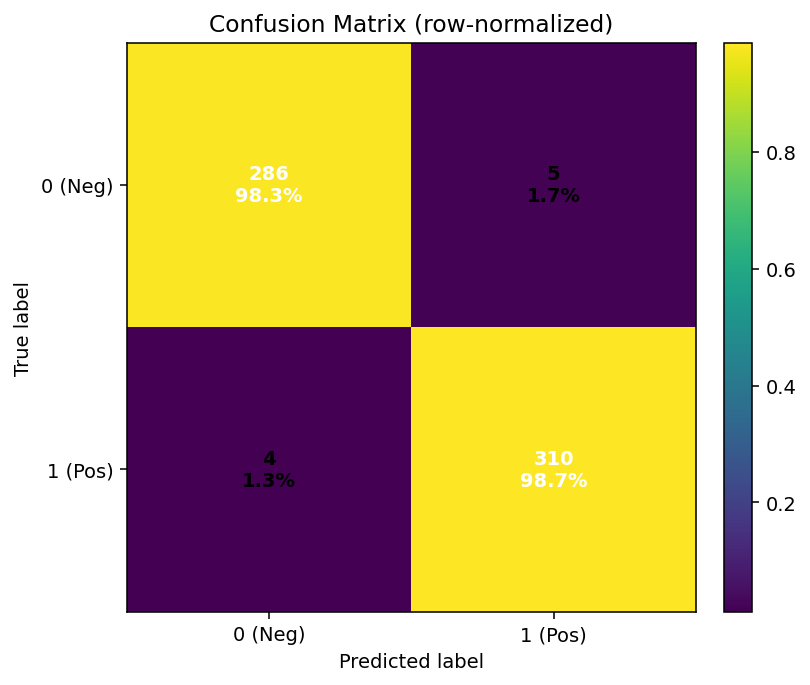

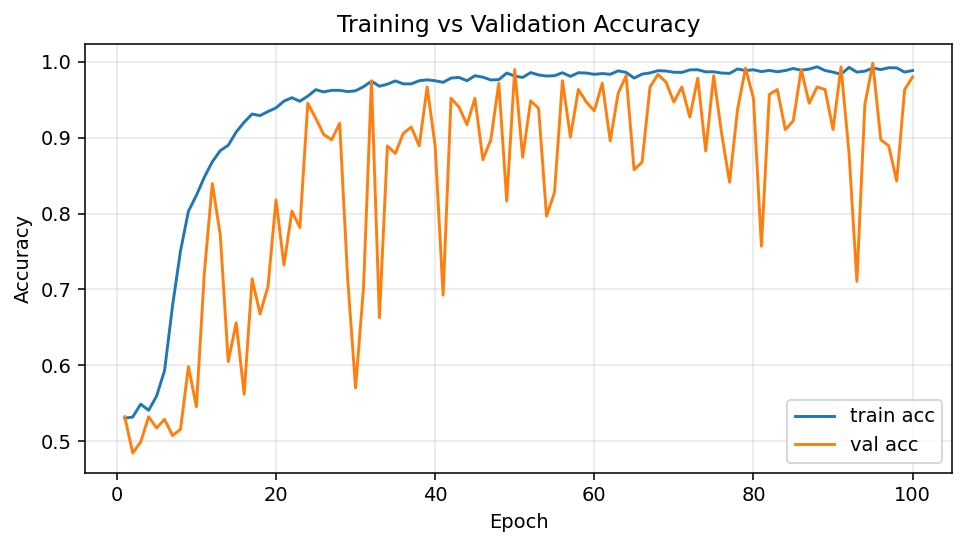

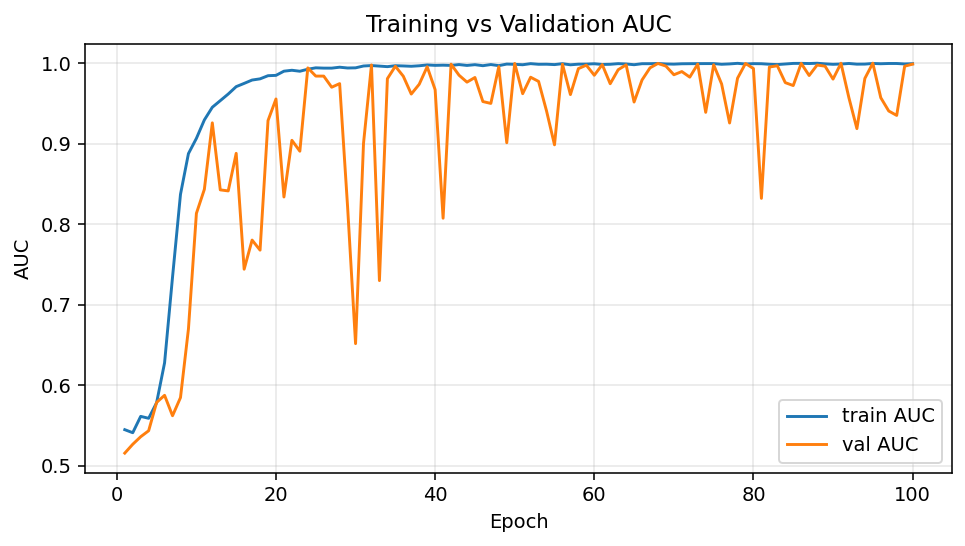

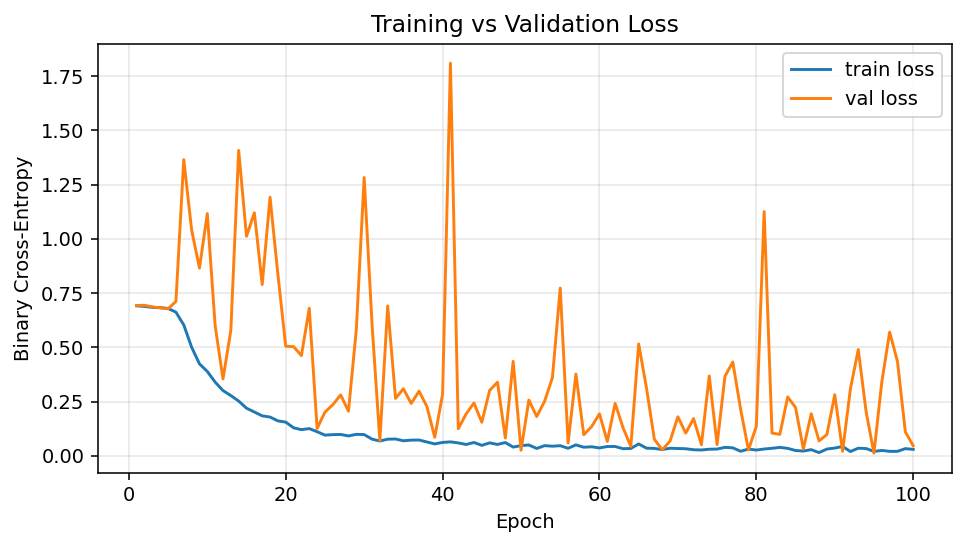

In [12]:
# === Pretty confusion matrix + training curves ===
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# ----- Confusion matrix (counts + percentages) -----
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

labels = ["0 (Neg)", "1 (Pos)"]
fig_cm, ax = plt.subplots(figsize=(6, 5), dpi=140)
im = ax.imshow(cm_norm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# ticks & labels
ax.set(
    xticks=np.arange(len(labels)),
    yticks=np.arange(len(labels)),
    xticklabels=labels,
    yticklabels=labels,
    xlabel="Predicted label",
    ylabel="True label",
    title="Confusion Matrix (row-normalized)"
)

plt.setp(ax.get_xticklabels(), rotation=0, ha="center")

# annotate each cell with "count\nxx.x%"
thresh = cm_norm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            f"{cm[i, j]}\n{cm_norm[i, j]*100:.1f}%",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > thresh else "black",
            fontsize=10, fontweight="bold"
        )

fig_cm.tight_layout()
plt.show()

# Optionally save:
# fig_cm.savefig("confusion_matrix_pretty.png", bbox_inches="tight", dpi=200)

# ----- Keras history plots: acc, AUC, loss -----
hist = history.history
epochs = np.arange(1, len(hist.get("loss", [])) + 1)

# Some codebases use different metric keys; handle both.
acc_key     = "acc"     if "acc"     in hist else "accuracy"
val_acc_key = "val_acc" if "val_acc" in hist else "val_accuracy"
auc_key     = "auc"
val_auc_key = "val_auc"

# 1) Accuracy
fig1, ax1 = plt.subplots(figsize=(7, 4), dpi=140)
ax1.plot(epochs, hist[acc_key],     label="train acc")
ax1.plot(epochs, hist[val_acc_key], label="val acc")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Accuracy")
ax1.set_title("Training vs Validation Accuracy")
ax1.grid(True, alpha=0.3)
ax1.legend()
fig1.tight_layout()
plt.show()
# fig1.savefig("history_accuracy.png", bbox_inches="tight", dpi=200)

# 2) AUC (if present)
if auc_key in hist and val_auc_key in hist:
    fig2, ax2 = plt.subplots(figsize=(7, 4), dpi=140)
    ax2.plot(epochs, hist[auc_key],     label="train AUC")
    ax2.plot(epochs, hist[val_auc_key], label="val AUC")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("AUC")
    ax2.set_title("Training vs Validation AUC")
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    fig2.tight_layout()
    plt.show()
    # fig2.savefig("history_auc.png", bbox_inches="tight", dpi=200)

# 3) Loss
if "loss" in hist and "val_loss" in hist:
    fig3, ax3 = plt.subplots(figsize=(7, 4), dpi=140)
    ax3.plot(epochs, hist["loss"],     label="train loss")
    ax3.plot(epochs, hist["val_loss"], label="val loss")
    ax3.set_xlabel("Epoch")
    ax3.set_ylabel("Binary Cross-Entropy")
    ax3.set_title("Training vs Validation Loss")
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    fig3.tight_layout()
    plt.show()


In [13]:
# --- Dataset sizes + class counts ---
def split_summary(name, files):
    n = len(files)
    ys = np.array([label_for_file(p) for p in files], dtype=int)
    n_pos = int((ys == 1).sum())
    n_neg = int((ys == 0).sum())
    print(f"{name:>6} size: {n:5d}  |  pos: {n_pos:4d}  neg: {n_neg:4d}  "
          f"|  pos%: {100.0 * n_pos / max(1, n):5.1f}")

print("\n--- Split summary ---")
split_summary("train", train_files)
split_summary("val",   val_files)
split_summary("test",  test_files)
print("---------------------\n")


--- Split summary ---
 train size:  4832  |  pos: 2505  neg: 2327  |  pos%:  51.8
   val size:   605  |  pos:  314  neg:  291  |  pos%:  51.9
  test size:   605  |  pos:  314  neg:  291  |  pos%:  51.9
---------------------



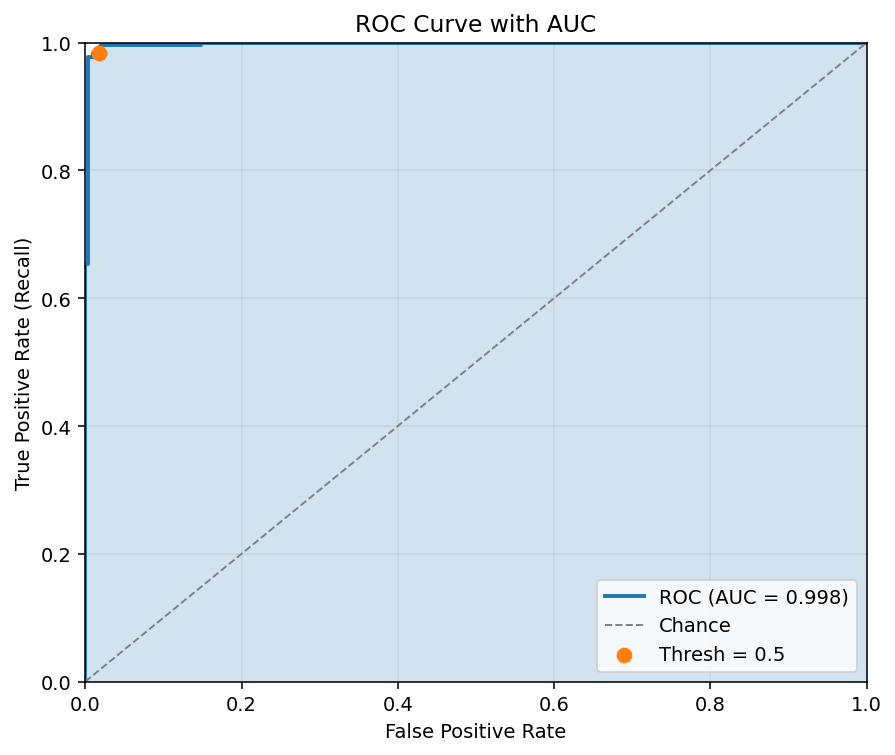

In [14]:
# --- ROC curve with shaded AUC and the 0.5-threshold operating point ---
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC
fpr, tpr, thr = roc_curve(y_true, probs1)
roc_auc = roc_auc_score(y_true, probs1)

# Find the point closest to threshold = 0.5 (for marking current operating point)
idx_05 = np.argmin(np.abs(thr - 0.5)) if len(thr) else None

plt.figure(figsize=(6.5, 5.5), dpi=140)
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC = {roc_auc:.3f})")
plt.fill_between(fpr, tpr, step="pre", alpha=0.2)

# Chance line
plt.plot([0, 1], [0, 1], linestyle="--", lw=1, color="gray", label="Chance")

# Mark operating point at threshold 0.5
if idx_05 is not None and 0 <= idx_05 < len(fpr):
    plt.scatter([fpr[idx_05]], [tpr[idx_05]], s=50, zorder=3, label="Thresh = 0.5")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve with AUC")
plt.grid(alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
